In [ ]:
from comparison_utils import *
import scipy
import stream2 as st2
%load_ext rpy2.ipython

def load_slingshot(res_path,slingshot_ncenters):
    %R -i res_path -i slingshot_ncenters
    %R path <- slingshot_ncenters
    curves_gmm = %R readRDS(paste(res_path,'slingshot_curves_gmm.rds',sep='_'))
    curves_kmeans = %R readRDS(paste(res_path,'slingshot_curves_kmeans',path,'.rds',sep='_'))
    cl1 = %R readRDS(paste(res_path,'slingshot_gmm.rds',sep='_'))
    cl2 = %R readRDS(paste(res_path,'slingshot_kmeans',path,'.rds',sep='_'))
    
    all_lineages = {}
    for n,curve in zip(['kmeans','GMM'],[curves_kmeans,curves_gmm]):
        lineages = dict(curve.items())
        for k,v in lineages.items():
            lineages[k] = dict(v.items())
            for k2,v2 in lineages[k].items():
                lineages[k][k2]=np.array(lineages[k][k2])
            lineages[k]['s']=lineages[k]['s'][lineages[k]['ord']-1]
        all_lineages[n]=lineages

    all_lineages['kmeans'] = [v['s'] for k,v in all_lineages['kmeans'].items()]
    all_lineages['GMM'] = [v['s'] for k,v in all_lineages['GMM'].items()]
    return all_lineages

def load_monocle(res_path,mcle_ncenters ,mcle_sigma,mcle_gamma):
    %R -i res_path -i mcle_ncenters -i mcle_sigma -i mcle_gamma
    path = %R path <- paste(mcle_ncenters,mcle_sigma,mcle_gamma,sep='_')
    path=path[0]
    nodep = %R readRDS(paste(res_path,'monocle_dp_mst',path,'.rds',sep='_'))
    nodep = np.array(nodep.T)
    stree = scipy.io.mmread(res_path+f'_monocle_stree_{path}_.mm')
    edges = np.argwhere(np.triu(stree.todense()))
    clus = %R readRDS(paste(res_path,'monocle_clus',path,'.rds',sep='_'))
    partitions = np.array(np.array(clus)[1])
    clusters = np.array(np.array(clus)[2])
    return nodep, stree, edges, partitions, clusters

def run_monocle_slingshot_tuned(data_path, res_path, slingshot_ncenters = 50,mcle_ncenters = 50,mcle_sigma = 0.01,mcle_gamma = 0.5,mcle_eps = 1e-05):
    ! /home/jo/anaconda3/envs/qz_monocle3/bin/Rscript run_monocle_slingshot_tuned.R $data_path $slingshot_ncenters $mcle_ncenters $mcle_sigma $mcle_gamma $mcle_eps $res_path
    
    lineages = load_slingshot(res_path,slingshot_ncenters)
    nodep, stree, edges, partitions, clusters = load_monocle(res_path,mcle_ncenters ,mcle_sigma ,mcle_gamma)
    return lineages, nodep, stree, edges, partitions, clusters

# Make synthetic data

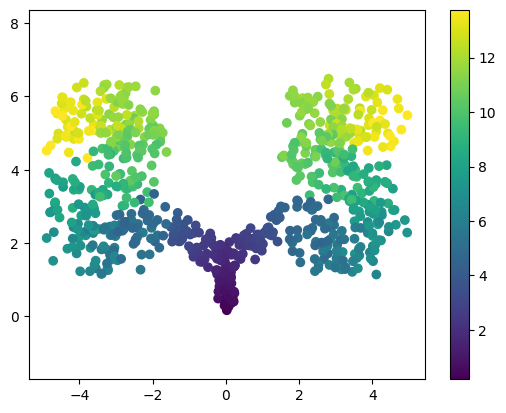

In [1]:
np.random.seed(0)
npoints=50
x = []
y = []
ps = []

x.append(np.zeros(npoints)+np.random.random(size=npoints)*.5-.25)
y.append(np.linspace(0,1,npoints)+np.random.random(size=npoints))

x.append(np.linspace(0,1.5,npoints))
y.append(np.linspace(1,2,npoints)+np.random.random(size=npoints)*1)
x.append(-np.linspace(0,1.5,npoints))
y.append(np.linspace(1,2,npoints)+np.random.random(size=npoints)*1)

ps.append(np.hstack(y)+np.hstack(np.abs(x)))

#----
#S curve 
#----
npoints_S=300
dim=2
d=1
angle = 0
noise = 1.5
min_ps = ps[-1].max()
t = 3 * np.pi * (np.random.random(npoints_S) - 0.5)

data = np.vstack([np.sin(t), np.sign(t) * (np.cos(t) - 1)]).T 
data += noise*np.random.random(size=(npoints_S,2))
r = np.sqrt(np.sum(data**2,axis=1))
phi = np.arctan2(data[:,1],data[:,0])

x.append(r*np.cos(phi-angle)+2.5)
y.append(r*np.sin(phi-angle)+3)
ps.append(-t+t.max()+min_ps)

data = np.vstack([np.sin(t), np.sign(t) * (np.cos(t) - 1)]).T 
data += noise*np.random.random(size=(npoints_S,2))
r = np.sqrt(np.sum(data**2,axis=1))
phi = np.arctan2(data[:,1],data[:,0])

x.append(-(r*np.cos(phi-angle)+2.5))
y.append(r*np.sin(phi-angle)+3)
ps.append(-t+t.max()+min_ps)

X=np.column_stack((np.hstack(x),np.hstack(y)))
c=np.hstack(ps)

plt.scatter(*X.T,c=c);plt.colorbar();plt.axis('equal');plt.show()
#np.savetxt('../data/synthetic/synthetic.csv',X.T.copy(),delimiter=',')
#np.savetxt('../data/synthetic/synthetic_ps.csv',c,delimiter=',')

# Load synthetic data

In [3]:
data_path = '../data/synthetic/synthetic.csv'
X = np.loadtxt(data_path,delimiter=',').T
c = np.loadtxt('../data/synthetic/synthetic_ps.csv',delimiter=',')
adata=sc.AnnData(X)
adata.obsm['X_dr']=X
adata.obs['ordinal_label']=c

# Default trajectories


Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")

<ipython-input-1-4d7636c95d08>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  partitions = np.array(np.array(clus)[1])
<ipython-input-1-4d7636c95d08>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clusters = np.array(np.array(clus)[2])


input data has shape 750 (samples) x 2 (features)
time is Sun Jul 23 13:36:45 2023
commencing global pruning
Share of edges kept after Global Pruning 51.05 %
number of components in the original full graph 1
for downstream visualization purposes we are also constructing a low knn-graph 
size neighbor array in low-KNN in pca-space for visualization (750, 5)
commencing community detection
time is Sun Jul 23 13:36:45 2023
19  clusters before handling small/big
There are 0 clusters that are too big
humanCD34 : global cluster graph pruning level 0.15
number of components before pruning 1
percentage links trimmed from local pruning relative to start 0.0
percentage links trimmed from global pruning relative to start 50.0
there are  1 components in the graph
root user [0]
start computing lazy-teleporting Expected Hitting Times


/home/jo/anaconda3/envs/c4/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


ended all multiprocesses, will retrieve and reshape
closeness  shortlist [0, 2, 3, 4, 5, 7, 10, 11, 13, 18]
betweeness shortlist [4, 7, 9, 10, 11, 12, 13, 14, 15, 17, 18]
out degree shortlist [0, 2, 4, 6, 7, 9, 11, 13, 15, 18]
TS 18 had 2 or more neighboring terminal states, namely [7, 10]  and so we removed, 10
terminal clus in this component [0, 2, 4, 7, 9, 11, 13, 15, 18]
final terminal clus [0, 2, 4, 7, 9, 11, 13, 15, 18]
From root 14  to Terminal state 0 is found 40  times.
From root 14  to Terminal state 2 is found 46  times.
From root 14  to Terminal state 4 is found 43  times.
From root 14  to Terminal state 7 is found 31  times.
From root 14  to Terminal state 9 is found 418  times.
From root 14  to Terminal state 11 is found 36  times.
From root 14  to Terminal state 13 is found 46  times.
From root 14  to Terminal state 15 is found 419  times.
From root 14  to Terminal state 18 is found 28  times.
terminal clusters [0, 2, 4, 7, 9, 11, 13, 15, 18]
project onto single cell
sta

/home/jo/anaconda3/envs/c4/lib/python3.8/site-packages/pyVIA/core.py:3127: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sct = ax.scatter(


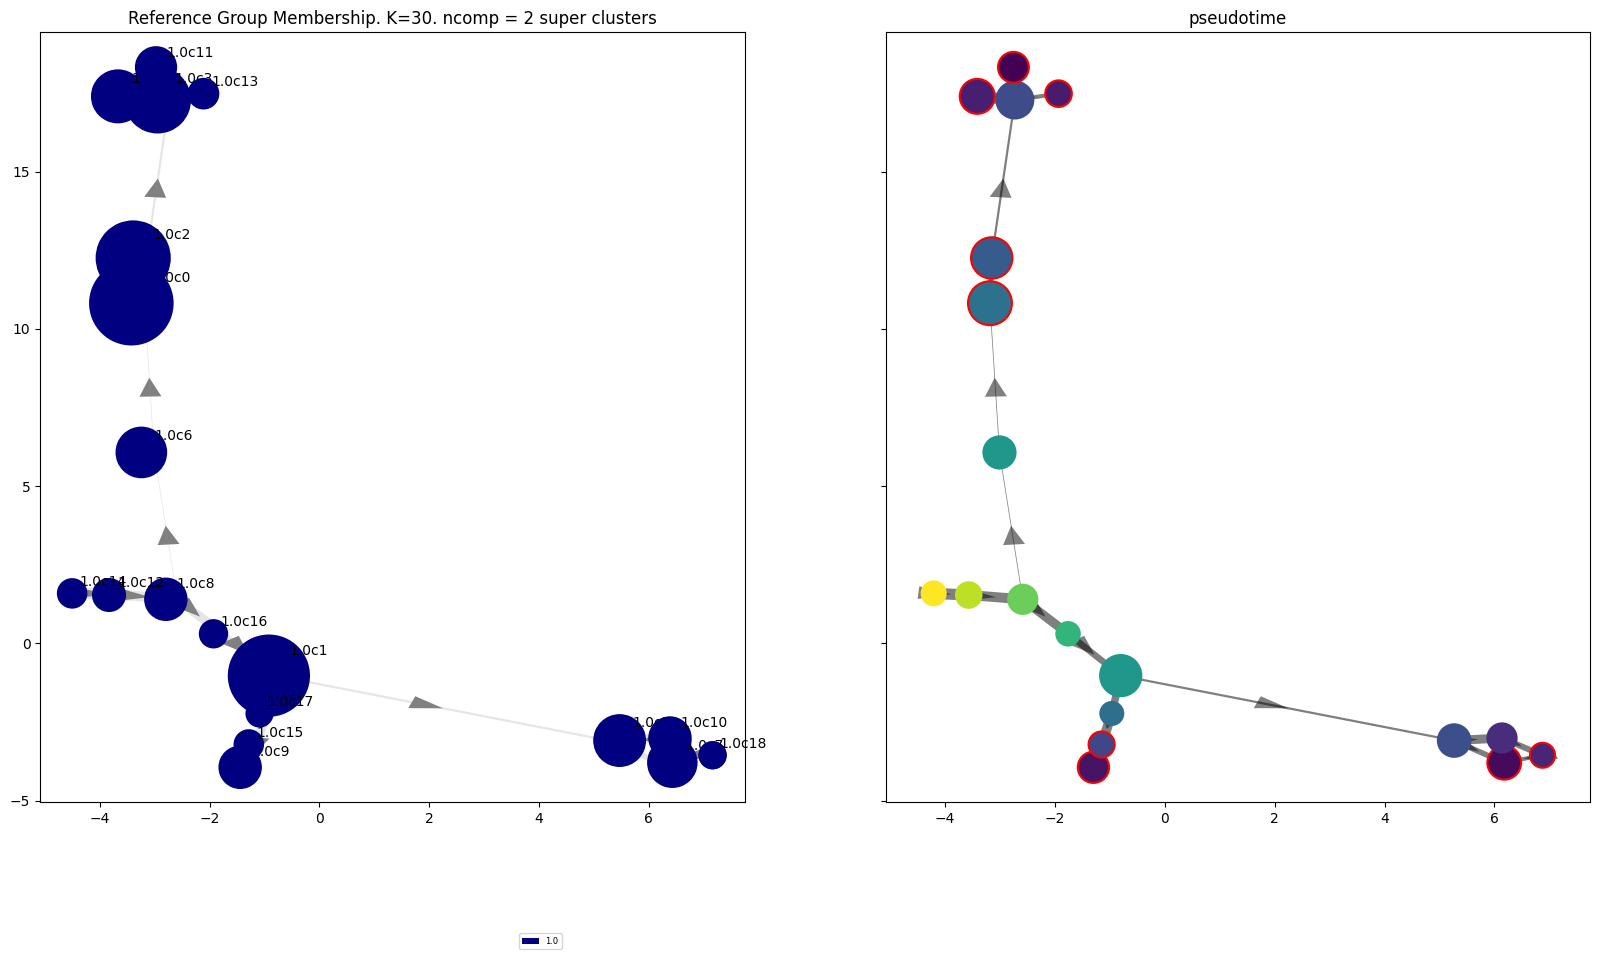

time elapsed 26.3 seconds
input data has shape 750 (samples) x 2 (features)
time is Sun Jul 23 13:37:11 2023
commencing global pruning
Share of edges kept after Global Pruning 49.67 %
commencing community detection
time is Sun Jul 23 13:37:11 2023
19  clusters before handling small/big
There are 9 clusters that are too big
too big is True  cluster 0 will be Expanded
cluster 7 is too big with population 38 . It will be expanded
cluster 6 is too big with population 42 . It will be expanded
cluster 5 is too big with population 43 . It will be expanded
cluster 4 is too big with population 44 . It will be expanded
cluster 2 is too big with population 45 . It will be expanded
cluster 1 is too big with population 63 . It will be expanded
cluster 0 is too big with population 69 . It will be expanded
humanCD34 : global cluster graph pruning level 0.15
number of components before pruning 1
percentage links trimmed from local pruning relative to start 0.0
percentage links trimmed from global prun

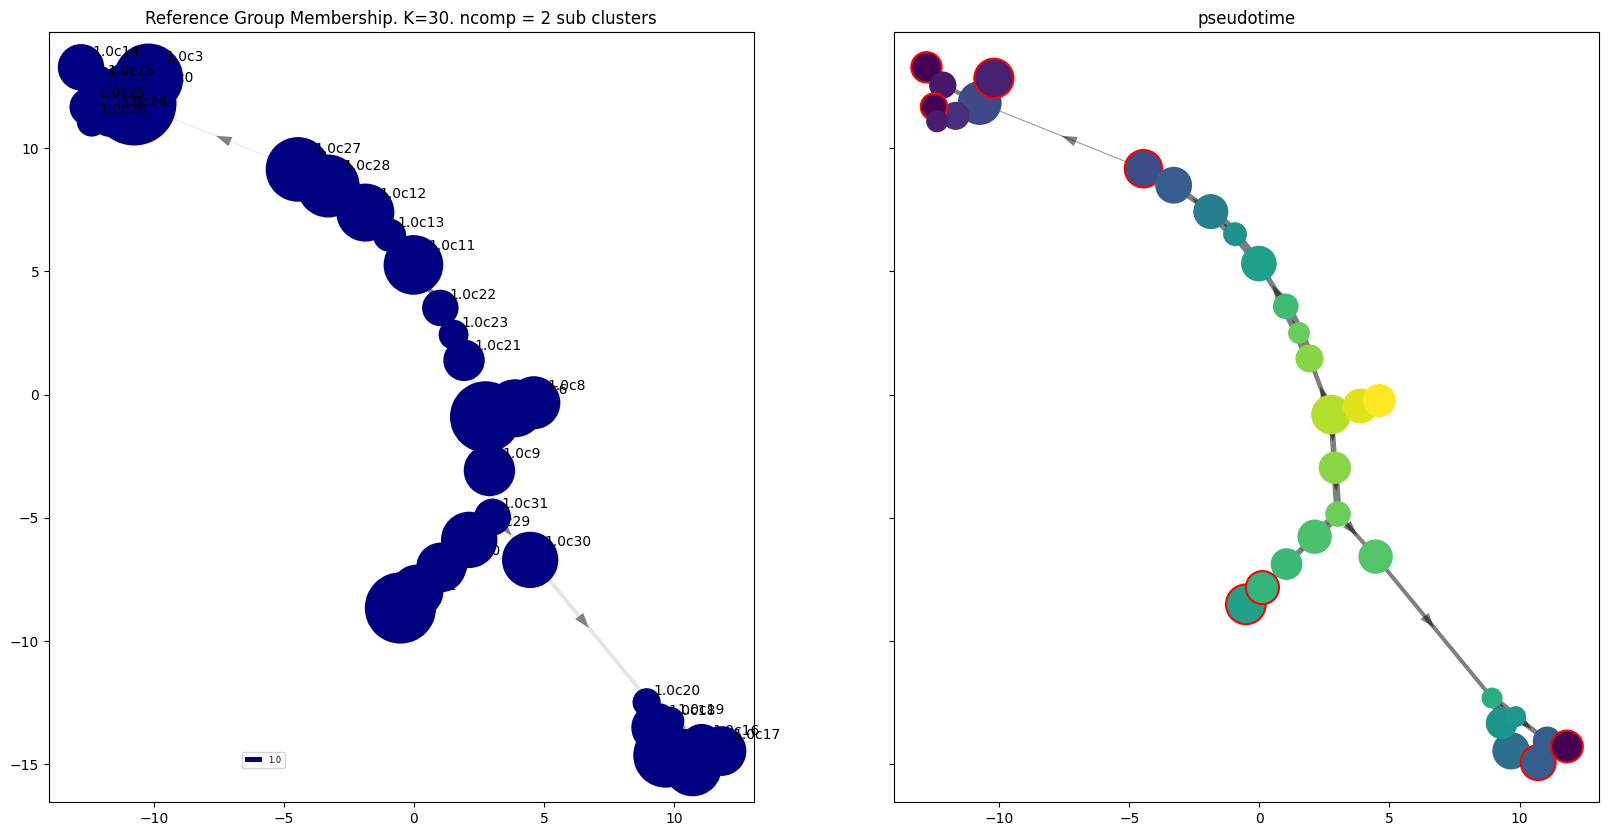

time elapsed 37.2 seconds
dict of terminal state pairs, Super: sub:  {2: 27, 4: 25, 7: 17, 9: 1, 11: 3, 13: 14, 15: 7, 18: 5}


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |#######################

super cluster 2 is a super terminal with sub_terminal cluster 27
super cluster 4 is a super terminal with sub_terminal cluster 25
super cluster 7 is a super terminal with sub_terminal cluster 17
super cluster 9 is a super terminal with sub_terminal cluster 1
super cluster 11 is a super terminal with sub_terminal cluster 3
super cluster 13 is a super terminal with sub_terminal cluster 14
super cluster 15 is a super terminal with sub_terminal cluster 7
super cluster 18 is a super terminal with sub_terminal cluster 5
Seeding initial graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...


In [4]:
import os
if not 'R_outputs' in os.listdir('.'): 
    os.mkdir('R_outputs')
if not 'synthetic' in os.listdir('R_outputs'): 
    os.mkdir('R_outputs/synthetic')

#default results
(slingshot_lineages, 
 mcle_nodep, mcle_stree, mcle_edges, 
 mcle_partitions, mcle_clusters) = run_monocle_slingshot_tuned(data_path, slingshot_ncenters = 50, 
                                                         mcle_ncenters = 50, mcle_sigma = 0.01, 
                                                         mcle_gamma = 0.5, mcle_eps = 1e-05,res_path='R_outputs/synthetic/')

((via_out, via_projected_sc_pt, 
 (loci, c_edge, width_edge, pen_color, dot_size)),_,_) = run_VIA(X,X,labels=None,root_user = [0], 
                                                            v0_too_big = 0.3 , v1_too_big = 0.05, v0_random_seed = 42, 
                                                            knn = 30,ncomps=2)

paga_nodep, paga_edges, paga_clus_points = run_paga(adata,X,resolution=1)

st2.tl.seed_graph(adata)
st2.tl.learn_graph(adata,n_nodes=50)
epg_nodep, epg_edges = adata.uns['epg']['node_pos'], adata.uns['epg']['edge']
st2.tl.learn_graph(adata,n_nodes=50,ordinal_label='ordinal_label',ordinal_root_point=c.argmin(),ordinal_supervision_strength=1)
sepg_nodep, sepg_edges = adata.uns['epg']['node_pos'], adata.uns['epg']['edge']

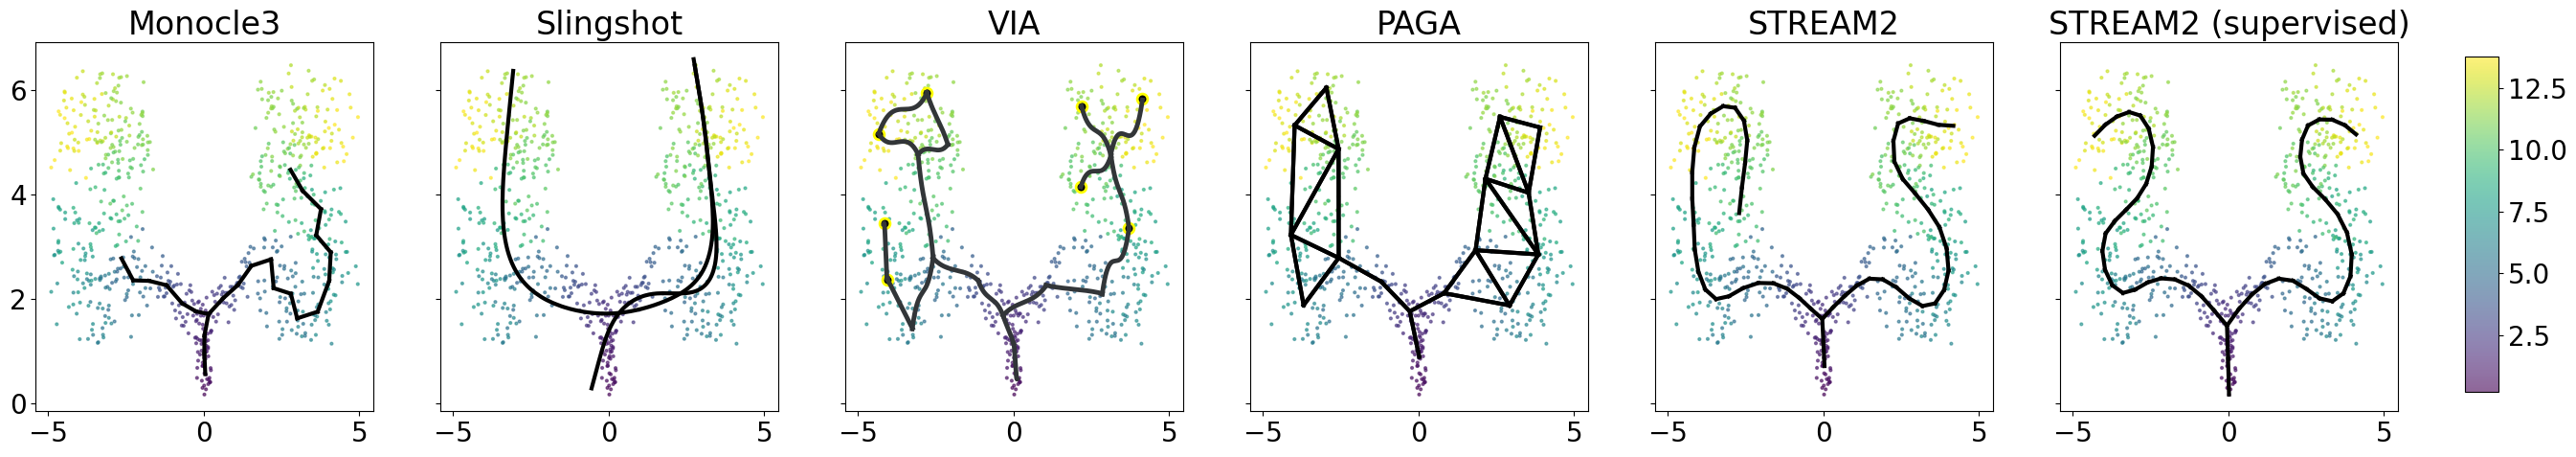

In [9]:
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(1, 6,figsize=(35,5),sharex=True,sharey=True)
axs=axs.flat

#monocle
ax=next(axs);ax.scatter(X[:,0],X[:,1],c=c,s=4,alpha=.6)
ax.set_title('Monocle3')
for e in mcle_edges:
    curve_i = np.concatenate((mcle_nodep[[e[0]]], mcle_nodep[[e[1]]]),axis=0).T
    ax.plot(curve_i[0], curve_i[1], c='k',linewidth=3)

#slingshot
ax=next(axs);ax.scatter(X[:,0],X[:,1],c=c,s=4,alpha=.6)
ax.set_title('Slingshot')
for l in slingshot_lineages['GMM']:
    curve_i = l.T
    ax.plot(curve_i[0], curve_i[1], c='k',linewidth=3)
    
#via
ax=next(axs);ax.scatter(X[:,0],X[:,1],c=c, alpha=0.6, s=4)
ax.set_title('VIA')
for i in range(len(via_out)): 
    ax.plot(via_out[i][0], via_out[i][1], linewidth=3.5, c='#323538')#1.5

    direction_arrow=via_out[i][2]; head_width=via_out[i][3]
    if direction_arrow == 1:
        ax.arrow(via_out[i][4], via_out[i][5], via_out[i][6], via_out[i][7], shape='full', lw=0, length_includes_head=False,
                  head_width=.02, color='#323538')  
count_ = 0
for i, c_e, w, pc, dsz in zip(loci, c_edge, width_edge, pen_color, dot_size):  # sc_supercluster_nn
    ax.scatter(X[i, 0], X[i, 1], c='black', s=dsz, edgecolors=c_e, linewidth=w)
    count_ = count_ + 1

#paga
ax=next(axs);ax.scatter(X[:,0],X[:,1],c=c,s=4,alpha=.6)
ax.set_title('PAGA')
for e in paga_edges:
    curve_i = np.concatenate((paga_nodep[[e[0]]], paga_nodep[[e[1]]]),axis=0).T
    ax.plot(curve_i[0], curve_i[1], c='k',linewidth=3)

#epg
ax=next(axs);_=ax.scatter(X[:,0],X[:,1],c=c,s=4,alpha=.6)
ax.set_title('STREAM2')
for edge_i in epg_edges:
    curve_i = np.concatenate((epg_nodep[[edge_i[0]]], epg_nodep[[edge_i[1]]]),axis=0).T
    ax.plot(curve_i[0], curve_i[1], c='k',linewidth=3)

#epg
ax=next(axs);_=ax.scatter(X[:,0],X[:,1],c=c,s=4,alpha=.6)
ax.set_title('STREAM2 (supervised)')
for edge_i in sepg_edges:
    curve_i = np.concatenate((sepg_nodep[[edge_i[0]]], sepg_nodep[[edge_i[1]]]),axis=0).T
    ax.plot(curve_i[0], curve_i[1], c='k',linewidth=3)
    
fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(_, cax=cbar_ax)
plt.savefig('figures/synthetic/synthetic_default.png',dpi=300,bbox_inches='tight')
plt.savefig('figures/synthetic/synthetic_default.pdf',dpi=300,bbox_inches='tight')

# Tuned

In [ ]:
# monocle, slingshot
for ncenters in (50,100,200):
    for mcle_sigma in (.00001,.0001,.001,.01,.1,1):
        for mcle_gamma in (.01,.1,.5,1,10):
            res_path='R_outputs/synthetic/'
            print(ncenters,mcle_sigma,mcle_gamma)
            if f'_monocle_dp_mst_{ncenters}_{mcle_sigma}_{mcle_gamma}_.rds' in os.listdir(res_path):
                continue
            try:
                run_monocle_slingshot_tuned(data_path, res_path=res_path,
                                            slingshot_ncenters = ncenters, mcle_ncenters = ncenters, 
                                            mcle_sigma = mcle_sigma, mcle_gamma = mcle_gamma, mcle_eps = 1e-05)
            except:
                pass

50 1e-05 0.01
50 1e-05 0.1
50 1e-05 0.5
50 1e-05 1
50 1e-05 10
50 0.0001 0.01

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioc

input data has shape 750 (samples) x 2 (features)
time is Thu Oct 14 12:24:26 2021
commencing global pruning
Share of edges kept after Global Pruning 49.34 %
number of components in the original full graph 1
for downstream visualization purposes we are also constructing a low knn-graph 
size neighbor array in low-KNN in pca-space for visualization (750, 5)
commencing community detection
time is Thu Oct 14 12:24:26 2021
94  clusters before handling small/big
There are 0 clusters that are too big
humanCD34 : global cluster graph pruning level 0.15
number of components before pruning 1
percentage links trimmed from local pruning relative to start 0.0
percentage links trimmed from global pruning relative to start 51.4
there are  1 components in the graph
root user [0]
start computing lazy-teleporting Expected Hitting Times
ended all multiprocesses, will retrieve and reshape
closeness  shortlist [0, 4, 10, 11, 12, 13, 16, 17, 18, 20, 21, 22, 24, 28, 29, 30, 32, 34]
betweeness shortlist [4, 

From root 14  to Terminal state 13 is found 5  times.
From root 14  to Terminal state 16 is found 5  times.
From root 14  to Terminal state 17 is found 5  times.
From root 14  to Terminal state 18 is found 5  times.
From root 14  to Terminal state 21 is found 234  times.
From root 14  to Terminal state 23 is found 243  times.


From root 14  to Terminal state 24 is found 5  times.


From root 14  to Terminal state 27 is found 207  times.
From root 14  to Terminal state 30 is found 221  times.
terminal clusters [34, 10, 11, 12, 13, 16, 17, 18, 21, 23, 24, 27, 30]
project onto single cell
start single cell projections of pseudotime and lineage likelihood
number of components before pruning 1
percentage links trimmed from local pruning relative to start 14.7
percentage links trimmed from global pruning relative to start 47.1


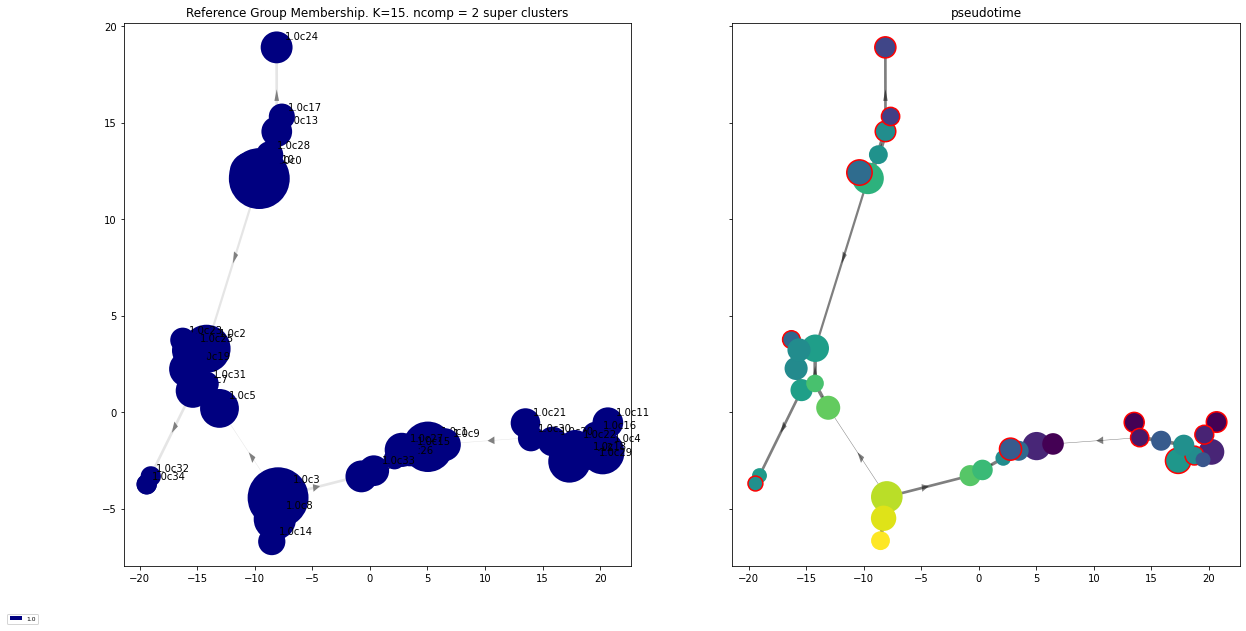

time elapsed 102.2 seconds
input data has shape 750 (samples) x 2 (features)
time is Thu Oct 14 12:26:07 2021
commencing global pruning
Share of edges kept after Global Pruning 49.34 %
commencing community detection
time is Thu Oct 14 12:26:07 2021
94  clusters before handling small/big
There are 0 clusters that are too big
humanCD34 : global cluster graph pruning level 0.15
number of components before pruning 1
percentage links trimmed from local pruning relative to start 0.0
percentage links trimmed from global pruning relative to start 51.4
there are  1 components in the graph
root user [0]
start computing lazy-teleporting Expected Hitting Times


ended all multiprocesses, will retrieve and reshape
super_terminal_clusters [34, 10, 11, 12, 13, 16, 17, 18, 21, 23, 24, 27, 30]
terminal clus in this component [34, 10, 11, 12, 13, 16, 17, 18, 21, 23, 24, 27, 30]
final terminal clus [34, 10, 11, 12, 13, 16, 17, 18, 21, 23, 24, 27, 30]


From root 14  to Terminal state 34 is found 16  times.
From root 14  to Terminal state 10 is found 5  times.


From root 14  to Terminal state 11 is found 5  times.


From root 14  to Terminal state 12 is found 5  times.


From root 14  to Terminal state 13 is found 5  times.


From root 14  to Terminal state 16 is found 5  times.
From root 14  to Terminal state 17 is found 5  times.


From root 14  to Terminal state 18 is found 5  times.


From root 14  to Terminal state 21 is found 234  times.
From root 14  to Terminal state 23 is found 243  times.


From root 14  to Terminal state 24 is found 5  times.
From root 14  to Terminal state 27 is found 207  times.


From root 14  to Terminal state 30 is found 221  times.
terminal clusters [34, 10, 11, 12, 13, 16, 17, 18, 21, 23, 24, 27, 30]
project onto single cell
start single cell projections of pseudotime and lineage likelihood
number of components before pruning 1
percentage links trimmed from local pruning relative to start 14.7
percentage links trimmed from global pruning relative to start 47.1


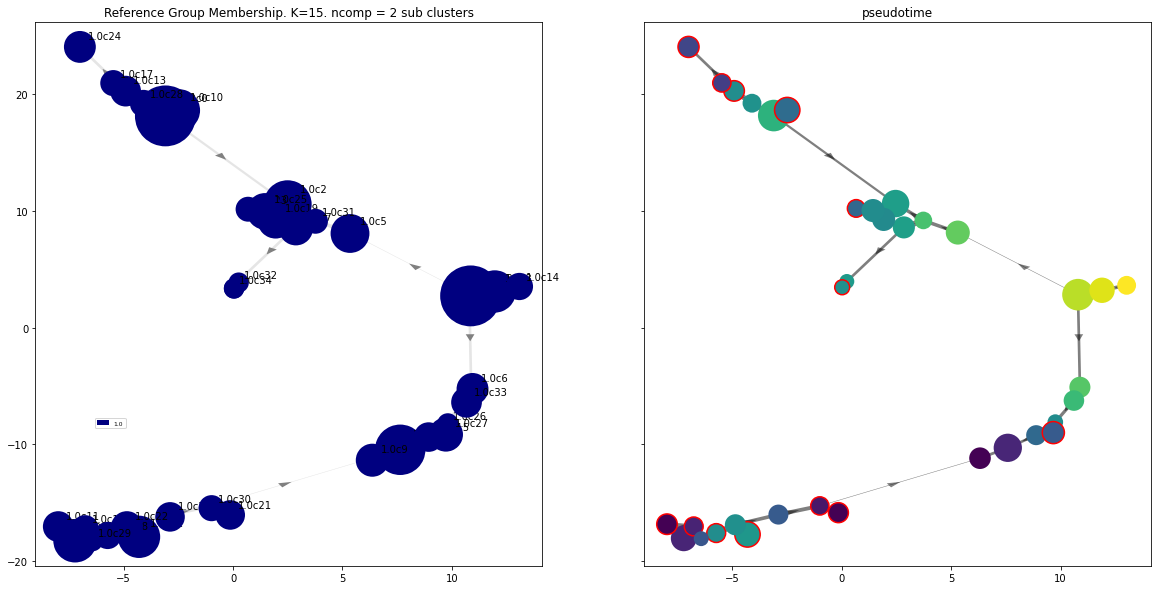

time elapsed 132.5 seconds
dict of terminal state pairs, Super: sub:  {34: 34, 10: 10, 11: 11, 12: 12, 13: 13, 16: 16, 17: 17, 18: 18, 21: 21, 23: 23, 24: 24, 27: 27, 30: 30}


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |#######################

super cluster 10 is a super terminal with sub_terminal cluster 34
super cluster 11 is a super terminal with sub_terminal cluster 10
super cluster 12 is a super terminal with sub_terminal cluster 11
super cluster 13 is a super terminal with sub_terminal cluster 12
super cluster 16 is a super terminal with sub_terminal cluster 13
super cluster 17 is a super terminal with sub_terminal cluster 16
super cluster 18 is a super terminal with sub_terminal cluster 17
super cluster 21 is a super terminal with sub_terminal cluster 18
super cluster 23 is a super terminal with sub_terminal cluster 21
super cluster 24 is a super terminal with sub_terminal cluster 23
super cluster 27 is a super terminal with sub_terminal cluster 24
super cluster 30 is a super terminal with sub_terminal cluster 27
super cluster 34 is a super terminal with sub_terminal cluster 30


TypeError: cannot unpack non-iterable NoneType object

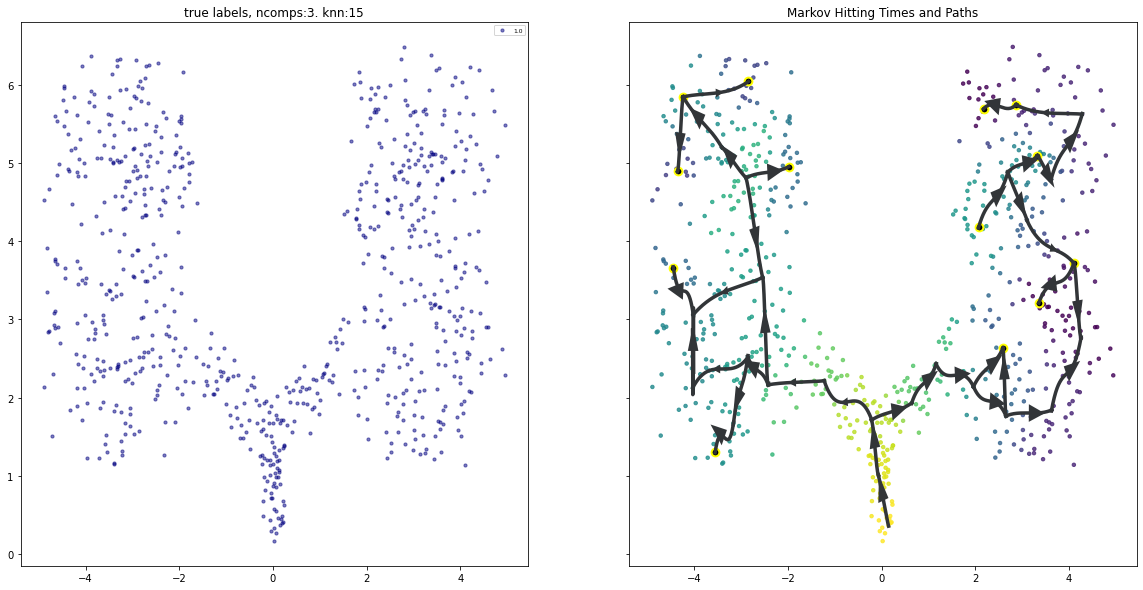

In [5]:
#paga, via, epg
all_via_out = {}
for knn in [15,20,30,50,100]:
    for dist_std_local in [.5,1,2,5,10]:
        for jac_std_global in [.05,.1,.15,.3,.5,1]:
            ((via_out, via_projected_sc_pt, 
             (loci, c_edge, width_edge, pen_color, dot_size)),
             (via_out2, via_projected_sc_pt2,
             (loci2, c_edge2, width_edge2, pen_color2, dot_size2)),
             (via_out3, via_projected_sc_pt3,
             (loci3, c_edge3, width_edge3, pen_color3, dot_size3)))  = run_VIA(
                X,X,labels=None,  root_user = [0], v0_too_big = 0.3 , v1_too_big = 0.05, v0_random_seed = 42, 
                knn = knn,ncomps=3,jac_std_global=jac_std_global,dist_std_local=dist_std_local)
            all_via_out[(knn,dist_std_local,jac_std_global)]=[via_out, via_projected_sc_pt, (loci, c_edge, width_edge, pen_color, dot_size)]

all_paga_out = {}
for resolution in [.1,.2,.5,1,1.2,1.5,2,3]:
    for knn in [15,20,30,50,100]:
        paga_nodep, paga_edges, paga_clus_points = run_paga(_anndata,X,resolution=resolution)
        all_paga_out[(knn,resolution)]=[paga_nodep, paga_edges, paga_clus_points]
            
with open('all_via_out_synthetic.pkl','wb') as f:
    pickle.dump(all_via_out,f)
with open('all_paga_out_synthetic.pkl','wb') as f:
    pickle.dump(all_paga_out,f)

NameError: name 'mcle_edges' is not defined

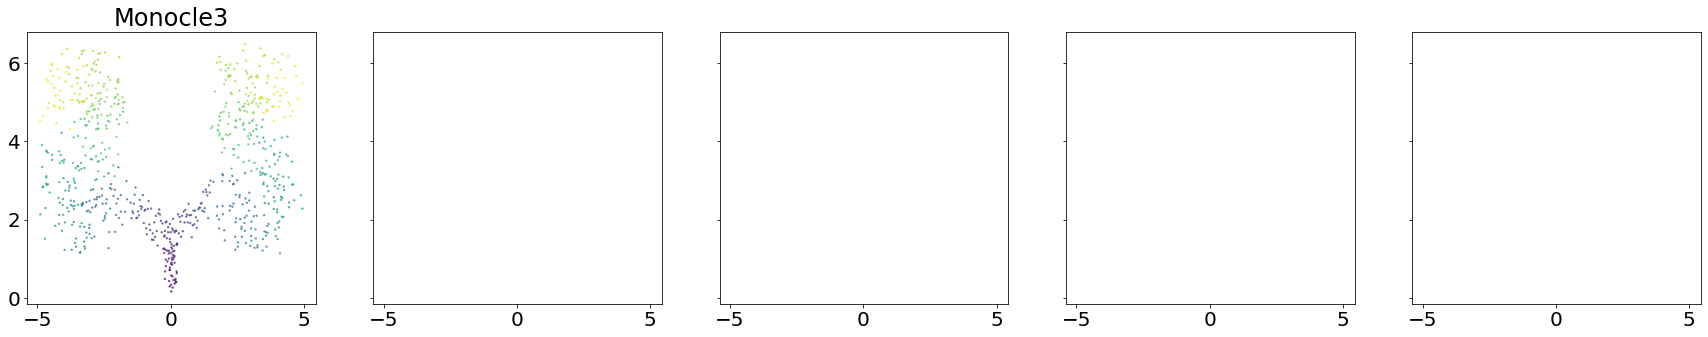

In [86]:
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(1, 5,figsize=(30,5),sharex=True,sharey=True)
axs=axs.flat

#monocle
ax=next(axs);ax.scatter(X[:,0],X[:,1],c=c,s=2,alpha=.6)
ax.set_title('Monocle3')
for e in mcle_edges:
    curve_i = np.concatenate((mcle_nodep[[e[0]]], mcle_nodep[[e[1]]]),axis=0).T
    ax.plot(curve_i[0], curve_i[1], c='k',linewidth=3)

#slingshot
ax=next(axs);ax.scatter(X[:,0],X[:,1],c=c,s=2,alpha=.6)
ax.set_title('Slingshot')
for l in slingshot_lineages['GMM']:
    curve_i = l.T
    ax.plot(curve_i[0], curve_i[1], c='k',linewidth=3)
    
#via
ax=next(axs);ax.scatter(X[:,0],X[:,1],c=c, alpha=0.6, s=3)
ax.set_title('VIA')
for i in range(len(via_out)): 
    ax.plot(via_out[i][0], via_out[i][1], linewidth=3.5, c='#323538')#1.5

    direction_arrow=via_out[i][2]; head_width=via_out[i][3]
    if direction_arrow == 1:
        ax.arrow(via_out[i][4], via_out[i][5], via_out[i][6], via_out[i][7], shape='full', lw=0, length_includes_head=False,
                  head_width=.02, color='#323538')  
count_ = 0
for i, c_e, w, pc, dsz in zip(loci, c_edge, width_edge, pen_color, dot_size):  # sc_supercluster_nn
    ax.scatter(X[i, 0], X[i, 1], c='black', s=dsz, edgecolors=c_e, linewidth=w)
    count_ = count_ + 1

#paga
ax=next(axs);ax.scatter(X[:,0],X[:,1],c=c,s=2,alpha=.6)
ax.set_title('PAGA')
for e in paga_edges:
    curve_i = np.concatenate((paga_nodep[[e[0]]], paga_nodep[[e[1]]]),axis=0).T
    ax.plot(curve_i[0], curve_i[1], c='k',linewidth=3)

#epg
ax=next(axs);_=ax.scatter(X[:,0],X[:,1],c=c,s=2,alpha=.6)
ax.set_title('STREAM2')
for edge_i in epg_edges:
    curve_i = np.concatenate((epg_nodep[[edge_i[0]]], epg_nodep[[edge_i[1]]]),axis=0).T
    ax.plot(curve_i[0], curve_i[1], c='k',linewidth=3)

fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(_, cax=cbar_ax)
plt.savefig('figures/synthetic_tuned.png',dpi=300,bbox_inches='tight')